In [1]:
''' GPR Implementation '''
import sys,os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns;sns.set()
from numpy.linalg import cholesky, det, lstsq, inv
from scipy.optimize import minimize
from sklearn.preprocessing import PolynomialFeatures
%matplotlib inline

In [2]:
''' Test Functions for Target Variable  '''
# def func(Xtr):
#     return Xtr*np.sin(Xtr)
def func2(Xtr):
    return 10.0 + Xtr**2 - 10.0*np.cos(2.0*np.pi*Xtr) 

''' 1. Covariance Function '''
def covfn(X1, X2, l=1.0, sigma_f=1.0):
    sqdist = np.sum(X1**2, 1).reshape(-1, 1) + np.sum(X2**2, 1) - 2 * np.dot(X1, X2.T)
    return sigma_f**2 * np.exp(-0.5 / l**2 * sqdist)

''' 3. buildkriging '''
def buildKriging(X,y,H,l,sigma_f,sigma_y):
    
    H = H                                                     # Collocation matrix
    Ht = H.T
    Kmat = covfn(X,X,l,sigma_f) + sigma_y**2 * np.eye(ntot) # Covar Mat (Train/Train)
    Kmat = inv(Kmat)
    
    HK = np.dot(Ht,Kmat)
    HKH = np.dot(HK,H)  # Regression matrix (Least Squares Matrix)
    A = inv(HKH)        
    
    W = np.dot(Kmat,y)
    Q = np.dot(Ht,W)
    beta = np.dot(A,Q)               # Regression coefficients
    V = W - np.dot(Kmat,H).dot(beta) # K^{-1} (Y - H^{T} * beta)
    
    return beta,V,W

''' Kriging Function Prediction '''
def KrigingFuncPredict(l,sigma_f,sigma_y,beta,V,W):
    
    Kmat = covfn(X,Xm,l,sigma_f)
    mu_s = np.dot(Kmat.T,W)  # Posterior Mean Prediction w/o additional term 
    yreg = np.dot(Hm,beta)   # Mean Prediction based on Regression
    ykr = np.dot(Kmat.T,V)   # posterior mean predictions for an explicit mean    

    return yreg + ykr, mu_s

''' Prediction of Variance '''
def KrigingVarPredict():
    

''' 2. Likelihood Equation '''
def llhfn(X_train, Y_train, noise, naive=True):
    
    def nll_naive(theta):
        # Naive implementation of Eq. (7). Works well for the examples 
        # in this article but is numerically less stable compared to 
        # the implementation in nll_stable below.
        K = covfn(X_train, X_train, l=theta[0], sigma_f=theta[1]) + \
            noise**2 * np.eye(len(X_train))
        return 0.5 * np.log(det(K)) + \
               0.5 * Y_train.T.dot(inv(K).dot(Y_train)) + \
               0.5 * len(X_train) * np.log(2*np.pi)

    def nll_stable(theta):
        # Numerically more stable implementation of Eq. (7) as described
        # in http://www.gaussianprocess.org/gpml/chapters/RW2.pdf, Section
        # 2.2, Algorithm 2.1.
        K = covfn(X_train, X_train, l=theta[0], sigma_f=theta[1]) + \
            noise**2 * np.eye(len(X_train))
        L = cholesky(K)
        return np.sum(np.log(np.diagonal(L))) + \
               0.5 * Y_train.T.dot(lstsq(L.T, lstsq(L, Y_train)[0])[0]) + \
               0.5 * len(X_train) * np.log(2*np.pi)
    
    if naive:
        return nll_naive
    else:
        return nll_stable

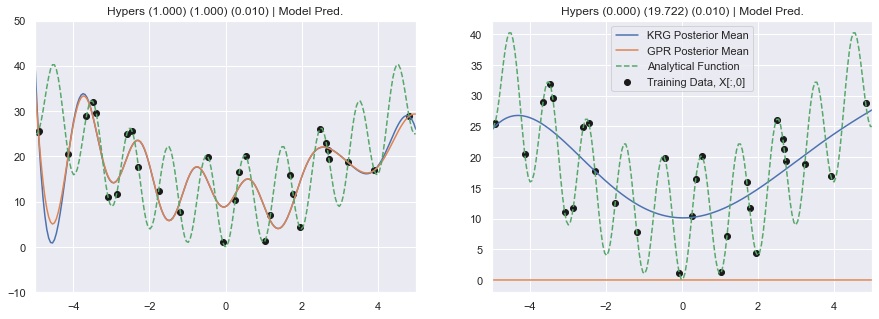

In [3]:
''' 1. Training/Test Data X/Xm '''
# Our feature matrix X[ndim,ntot] contains only 1 feature, geometrical x value
ntot = 30    # lets have this many training data nodes
mtot = 200  # and this many test data nodes

# Training / Test Feature Matrices
X = np.random.uniform(-5,5,(ntot,1))
Xm = np.linspace(start=-5,stop=5,num=mtot).reshape(-1,1)
y = func2(X)

# Collocation Matrix
poly = PolynomialFeatures(5)
H = poly.fit_transform(X)
Hm = poly.fit_transform(Xm)
#H = np.ones((stot,ntot))
#Hm = np.ones((stot,mtot))

''' Hyperparameters '''
# Need to define some initial hyperparameters to create a model
l = 1.0
sigma_f = 1.0
sigma_y = 0.01

beta,V,W = buildKriging(X,y,H,l,sigma_f,sigma_y)
ypred,mu_s = KrigingFuncPredict(l,sigma_f,sigma_y,beta,V,W)

fig, axs = plt.subplots(1,2,figsize=(15,5))
axs[0].plot(Xm[:,0],ypred[:,0],label='KRG Posterior Mean')
axs[0].plot(Xm[:,0],mu_s,label='GPR Posterior Mean')
axs[0].scatter(X[:,0],y[:,0],label='Training Data, X[:,0]',c='k')
axs[0].plot(Xm[:,0],func2(Xm[:,0]),label='Analytical Function',ls='--')
axs[0].set_title(f'Hypers ({l:.3f}) ({sigma_f:.3f}) ({sigma_y:.3f}) | Model Pred.')
axs[0].set_xlim(-5,5);axs[0].set_ylim(-10,50)

# optimise hyperparameters l,sigma_f 
res = minimize(llhfn(X,y,sigma_y), [1, 1], 
               bounds=((1e-5, None), (1e-5, None)),
               method='L-BFGS-B')
l_opt,sigma_f_opt = res.x

beta,V,W = buildKriging(X,y,H,l_opt,sigma_f_opt,sigma_y)
ypred,mu_s = KrigingFuncPredict(l_opt,sigma_f_opt,sigma_y,beta,V,W)

axs[1].plot(Xm[:,0],ypred[:,0],label='KRG Posterior Mean')
axs[1].plot(Xm[:,0],mu_s,label='GPR Posterior Mean')
axs[1].scatter(X[:,0],y[:,0],label='Training Data, X[:,0]',c='k')
axs[1].plot(Xm[:,0],func2(Xm[:,0]),label='Analytical Function',ls='--')
axs[1].set_title(f'Hypers ({l_opt:.3f}) ({sigma_f_opt:.3f}) ({sigma_y:.3f}) | Model Pred.')
axs[1].set_xlim(-5,5);axs[0].set_ylim(-10,50)
plt.legend()